In [1]:
import pandas as pd
#Dataimport
data_link="https://raw.githubusercontent.com/Nicki-Bladal/Estimating_Japan_Real_Estate_Pricing_Machine_Learning/master/01.csv"
data_df = pd.read_csv(data_link,parse_dates=True,index_col="No")

In [2]:
#Checking datatypes and non-null counts
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186238 entries, 1 to 186238
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Type                         186238 non-null  object 
 1   Region                       133069 non-null  object 
 2   MunicipalityCode             186238 non-null  int64  
 3   Prefecture                   186238 non-null  object 
 4   Municipality                 186238 non-null  object 
 5   DistrictName                 183567 non-null  object 
 6   NearestStation               145929 non-null  object 
 7   TimeToNearestStation         144490 non-null  object 
 8   MinTimeToNearestStation      144490 non-null  float64
 9   MaxTimeToNearestStation      140917 non-null  float64
 10  TradePrice                   186238 non-null  int64  
 11  FloorPlan                    20486 non-null   object 
 12  Area                         186238 non-null  int64  
 13 

Removing obvious problematic features
-

In [3]:
#TimeToNearestStation and MaxTimeToNearestStation are removed not to have 3 time factors
del data_df['MaxTimeToNearestStation']
del data_df['TimeToNearestStation']    

#Municipality is dropped as Municipality code will suffice
del data_df['Municipality']

#Period is removed as Year + Quarter contain same info
del data_df['Period']

#All data comes from same prefecture which is therefore kept out
del data_df['Prefecture']

In [4]:
# TotalFloorAreaIsGreaterFlag and FrontageIsGreaterFlag are always True and is therefore removed
data_df.TotalFloorAreaIsGreaterFlag.notnull().mean()

del data_df['TotalFloorAreaIsGreaterFlag']
del data_df['FrontageIsGreaterFlag']

Addressing features with few observations
-

In [5]:
import numpy as np
#Remarks has very few values we inspect it
data_df.Remarks.value_counts()

# Turns out that a missing remark in most case equals "no remarks" (which is a positive value) therefor we input that value

data_df.Remarks = data_df.Remarks.replace(np.nan, 'No remarks', regex=True)

In [6]:
#FloorPlan has very few values we inspect it
data_df.FloorPlan.value_counts()

# Missing value for floorplan is hard to imput - therefor we put in the value missing, as not to assume a specific floorplan
data_df.FloorPlan = data_df.FloorPlan.replace(np.nan, 'Unknown', regex=True)

In [7]:
#FloorPlan has very few values we inspect it
data_df.Renovation.value_counts()

# We put in the value unknown, for na in Renovation
data_df.Renovation = data_df.Renovation.replace(np.nan, 'Unknown', regex=True)

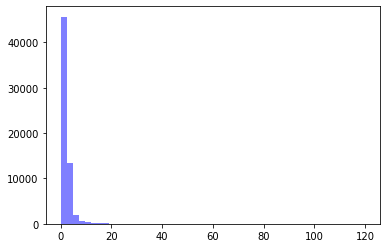

In [8]:
#Investigating Total floor Area divided with Area

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = (data_df.Area / data_df.TotalFloorArea)
num_bins = 50
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [9]:
#Finding exact conversion between Area and TotalFloorArea
print("Area is", (data_df.Area / data_df.TotalFloorArea).mean(), "times bigger than TotalFloorArea, with a standard diviation of", (data_df.Area / data_df.TotalFloorArea).std())
print("TotalFloorArea, has", (data_df.TotalFloorArea.isna().sum()), "empty cells")

#We repleace with 2.26xArea for missing values
data_df.TotalFloorArea = data_df.TotalFloorArea.fillna(data_df.Area*2.26)

Area is 2.26197300662067 times bigger than TotalFloorArea, with a standard diviation of 2.40680752854744
TotalFloorArea, has 123748 empty cells


Dataleakage
-

In [10]:
#PricePerTsubo is directly related to Price and is therefore a DataLeakage source which must be removed
del data_df['PricePerTsubo']


In [11]:
# Testing Area vs AreaIsGreaterFlag 
print("AreaIsGreaterFlag is a bool, the avg val is",data_df.AreaIsGreaterFlag.mean(), "ie.", (1-data_df.AreaIsGreaterFlag.mean())*100, "% values are False")
print("Area is an int, the fraction of observations not equal to zero is",data_df.Area.notnull().mean())

#AreaIsGreaterFlag is kept

AreaIsGreaterFlag is a bool, the avg val is 0.12009364361730689 ie. 87.99063563826931 % values are False
Area is an int, the fraction of observations not equal to zero is 1.0


Sorting strings and numbers
-

In [12]:
# Investigating "Cardinality" 
object_cols = [cname for cname in data_df.columns if data_df[cname].dtype == "object"]

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: data_df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
print("Listed Categorical variables and Cardinity")
sorted(d.items(), key=lambda x: x[1])

Listed Categorical variables and Cardinity


[('Renovation', 3),
 ('Region', 4),
 ('Type', 5),
 ('Purpose', 6),
 ('LandShape', 9),
 ('Direction', 9),
 ('Classification', 14),
 ('CityPlanning', 16),
 ('Remarks', 18),
 ('Structure', 22),
 ('FloorPlan', 27),
 ('Use', 115),
 ('NearestStation', 461),
 ('DistrictName', 4641)]

In [13]:
# As the cardinality spans from 2 to more than 4500 we cannot use HotPot imputation for all strings - therefor we divide at cardinality > 10
low_cardinality_cols = [cname for cname in data_df.columns if data_df[cname].nunique() < 10 and data_df[cname].dtype == "object"]

high_cardinality_cols = [cname for cname in data_df.columns if data_df[cname].nunique() > 10 and data_df[cname].dtype == "object"]

# Numericalcolumns
numerical_cols = [cname for cname in data_df.columns if data_df[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + high_cardinality_cols + numerical_cols
data_v1 = data_df[my_cols].copy()

In [14]:

print(data_v1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186238 entries, 1 to 186238
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     186238 non-null  object 
 1   Region                   133069 non-null  object 
 2   LandShape                132674 non-null  object 
 3   Purpose                  56882 non-null   object 
 4   Direction                132631 non-null  object 
 5   Renovation               186238 non-null  object 
 6   DistrictName             183567 non-null  object 
 7   NearestStation           145929 non-null  object 
 8   FloorPlan                186238 non-null  object 
 9   Structure                81430 non-null   object 
 10  Use                      81249 non-null   object 
 11  Classification           129636 non-null  object 
 12  CityPlanning             152003 non-null  object 
 13  Remarks                  186238 non-null  object 
 14  Muni